In [1]:
!pip install numpy pandas matplotlib scikit-learn tensorflow keras opencv-python




[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [12]:
!pip install scikit-image
!pip install imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 1.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.4/315.4 kB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.2/228.2 kB 1.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


# 3

Step 1: Import necessary libraries.

Step 2: Load the dataset, resizing the images to 128x128 pixels.

Step 3: Apply the watershed algorithm to extract features from each image.

Step 4: Split the data into training and testing sets.

Step 5: Optionally apply SMOTE to handle any imbalanced datasets.

Step 6: Scale the features using StandardScaler.

Step 7: Train the MLP model using grid search to optimize hyperparameters.

Step 8: Plot the loss function during training.

Step 9: Display the predicted output for some of the test images.




In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from imblearn.over_sampling import SMOTE  # For handling imbalanced data


Load the dataset, resizing the images to 128x128 pixels.




In [2]:
base_path = "./MaleandFemalefacedataset"


# Load images and labels
def load_images(base_path, image_size=(128, 128)):  # Resize to 128x128 by default
    images = []
    labels = []
    for label, folder in enumerate(['Female_Faces', 'Male_Faces']):
        folder_path = os.path.join(base_path, folder)
        for file_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Resize image to 128x128
                img_resized = cv2.resize(img, image_size)
                images.append(img_resized)
                labels.append(label)  # 0 for Female, 1 for Male
    return np.array(images), np.array(labels)

# Load images and labels with resizing
images, labels = load_images(base_path)

# Print the number of images loaded
print(f'Number of images loaded: {len(images)}')


Number of images loaded: 5418


 Apply the watershed algorithm to extract features from each image.
 

In [3]:
# Feature extraction using Watershed Algorithm
def apply_watershed(image):
    # Apply Otsu's threshold to get a binary image
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Remove small noise using morphological operations
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Get sure background by dilating the result
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Get sure foreground area using distance transform
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Get unknown region (where sure_fg and sure_bg overlap)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Markers for watershed
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Apply watershed
    image_colored = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(image_colored, markers)
    image_colored[markers == -1] = [255, 0, 0]  # Mark the boundaries in red

    return markers.flatten()

# Apply the watershed algorithm to all images to extract features
features = [apply_watershed(img) for img in images]
features = np.array(features)

# Print feature shape
print(f'Feature shape: {features.shape}')


Feature shape: (5418, 16384)


Split the data into training and testing sets.

In [4]:
# Split data into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


apply SMOTE to handle any imbalanced datasets.

In [5]:
# Apply SMOTE for balancing the dataset 
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)


Scale the features using StandardScaler.

In [6]:
# Apply StandardScaler to scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train the MLP model using grid search to optimize hyperparameters.

In [7]:
param_grid = {
    'hidden_layer_sizes': [(128,), (64, 64)],  # Fewer hidden layer combinations
    'activation': ['relu'],  # Focus on 'relu' since it's generally more efficient
    'solver': ['adam'],  # 'adam' is faster than 'sgd' for MLP
    'alpha': [0.0001],  # Fewer regularization options
}


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Set up GridSearchCV with the MLPClassifier and the defined parameter grid
grid_search = GridSearchCV(
    MLPClassifier(max_iter=300, random_state=42),  # Use a lower max_iter for faster convergence
    param_grid=param_grid,  # Use the parameter grid defined earlier
    cv=3,  # 3-fold cross-validation
    n_jobs=-1  # Use all available CPU cores for faster processing
)


In [9]:
# Fit the model on the scaled training data
grid_search.fit(X_train_scaled, y_train)


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=300, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.0001],
                         'hidden_layer_sizes': [(128,), (64, 64)],
                         'solver': ['adam']})

In [10]:
# Get the best model from grid search
mlp_best = grid_search.best_estimator_

# Print the best parameters
print(f'Best Parameters: {grid_search.best_params_}')


Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'solver': 'adam'}


In [11]:
# Predict on the test set using the best model
y_pred_best = mlp_best.predict(X_test_scaled)


In [12]:
from sklearn.metrics import accuracy_score

# Calculate accuracy on the test set
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Best Accuracy: {accuracy_best * 100:.2f}%')


Best Accuracy: 97.88%


 Plot the loss function during training.

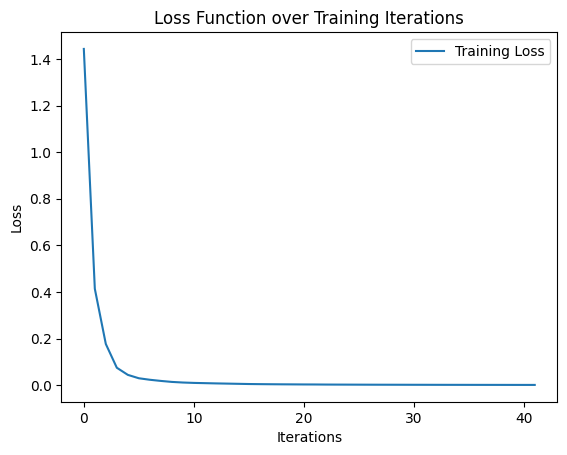

In [13]:
import matplotlib.pyplot as plt

# Plot the loss curve
plt.plot(mlp_best.loss_curve_, label='Training Loss')
plt.title('Loss Function over Training Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'solver': 'adam'}
Best Accuracy: 97.88%


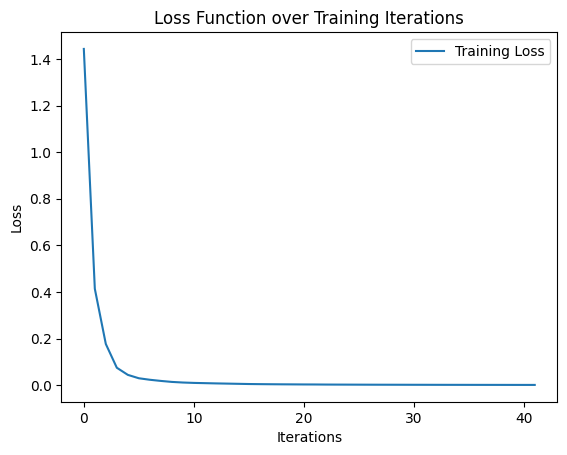

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set up GridSearchCV
grid_search = GridSearchCV(
    MLPClassifier(max_iter=300, random_state=42), 
    param_grid=param_grid, 
    cv=3,  # 3-fold cross-validation
    n_jobs=-1  # Use all CPU cores
)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Get the best model and parameters
mlp_best = grid_search.best_estimator_
print(f'Best Parameters: {grid_search.best_params_}')

# Predict on the test set
y_pred_best = mlp_best.predict(X_test_scaled)

# Calculate accuracy
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Best Accuracy: {accuracy_best * 100:.2f}%')

# Plot the loss curve
plt.plot(mlp_best.loss_curve_, label='Training Loss')
plt.title('Loss Function over Training Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()


Display in segmentation 

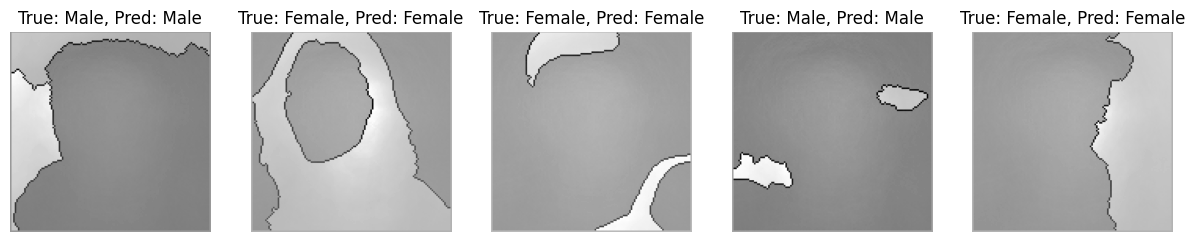

In [24]:
import numpy as np

# Function to map the labels to 'Male' and 'Female'
def label_mapping(label):
    return 'Male' if label == 1 else 'Female'

# Function to display random original images with predictions and true labels
def display_random_predictions(X_test_original, y_test, y_pred, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    # Select random indices based on the length of y_test (since y_test and y_pred are from the test set)
    random_indices = np.random.choice(len(y_test), num_samples, replace=False)

    # Show random original images along with true and predicted labels
    for i, idx in enumerate(random_indices):
        axes[i].imshow(X_test_original[idx].reshape(128, 128), cmap='gray')  # Display original images
        axes[i].set_title(f"True: {label_mapping(y_test[idx])}, Pred: {label_mapping(y_pred[idx])}")
        axes[i].axis('off')
    plt.show()

# Show 5 random predictions from the test set with original images and text labels
display_random_predictions(X_test_scaled, y_test, y_pred_best, num_samples=5)


Display in original photo

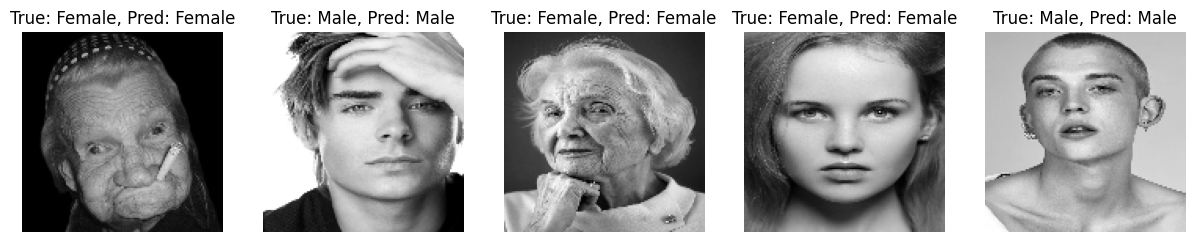

In [26]:
import numpy as np

# Perform the train-test split and retain the original indices
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    features, labels, np.arange(len(images)), test_size=0.2, random_state=42
)

# Function to map the labels to 'Male' and 'Female'
def label_mapping(label):
    return 'Male' if label == 1 else 'Female'

# Function to display random original images with predictions and true labels
def display_random_predictions(original_images, test_indices, y_test, y_pred, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    # Select random indices based on the length of y_test
    random_indices = np.random.choice(len(y_test), num_samples, replace=False)

    # Show random original images along with true and predicted labels
    for i, idx in enumerate(random_indices):
        original_idx = test_indices[idx]  # Map back to original image index
        axes[i].imshow(original_images[original_idx].reshape(128, 128), cmap='gray')  # Display original images
        axes[i].set_title(f"True: {label_mapping(y_test[idx])}, Pred: {label_mapping(y_pred[idx])}")
        axes[i].axis('off')
    plt.show()

# Show 5 random predictions from the test set with original images and text labels
display_random_predictions(images, indices_test, y_test, y_pred_best, num_samples=5)
